# Make sure that you are using the same version of python and sklearn for compatibility

In [1]:
from platform import python_version
print(python_version())
import sklearn
print((sklearn.__version__) )

3.9.16
1.2.1


In [2]:
import sys
required_version = (3, 9, 0)  # The minimum required Python version
if sys.version_info < required_version:
    raise ValueError(f"Python version {required_version[0]}.{required_version[1]} or higher is required, but current version is {sys.version_info[0]}.{sys.version_info[1]}")
else:
    print('The minimum required Python version is satisfied!')

required_version_sklearn = (1, 2, 1)  # The minimum required sklearn version
your_sklearn_version = (int(sklearn.__version__[0]),int(sklearn.__version__[2]),int(sklearn.__version__[4]))
if your_sklearn_version < required_version_sklearn:
    raise ValueError(f"Sklearn version {required_version_sklearn[0]}.{required_version_sklearn[1]} or higher is required, but current version is {your_sklearn_version[0]}.{your_sklearn_version[1]}")
else:
    print('The minimum required sklearn version is satisfied!')

The minimum required Python version is satisfied!
The minimum required sklearn version is satisfied!


In [3]:
import time
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pickle
import requests
import os
import joblib
import gzip

## Load the saved models

first dowonload the saved models in pickle format from gitub (.sav files)
* https://github.com/farhadseda/ML-Based-GMMs-for-NGA-West2

In [4]:
# load the model from disk
with gzip.open('ANN.sav.gz', 'rb') as f:
        ANN = pickle.load(f)
        
with gzip.open('KRR.sav.gz', 'rb') as f:
        KRR = pickle.load(f)
        
with gzip.open('RFR.sav.gz', 'rb') as f:
        RFR = pickle.load(f)
        
with gzip.open('SVR.sav.gz', 'rb') as f:
        SVR = pickle.load(f)

## Function to plot the distance scaling

In [5]:
# plot distance scaling
def plot_dist_scaling(df_plot, predicted):
    # plt.figure(figsize = (8,7))
    color = ['purple','blue','green','yellow','red','black']
    styles = ['-','--','-.','-','--']
    d = list(set(df_plot['ClstD_km'].tolist()))
    d.sort()
    for m, j,style in zip(df_plot.Earthquake_Magnitude.unique(),color, styles):
        plt.loglog(d, np.exp(predicted[df_plot.Earthquake_Magnitude == m]), style, linewidth=3, color = j, label = 'M'+str(m))
       
    plt.legend()
    plt.xlabel('Rupture Distance (km)')
    plt.ylabel('Acceleration (g)')
    plt.ylim([0.000001, 10])
    plt.xlim([1, 300])

## Function to create the dataframe for prediction

In [6]:
# function to create the data needed for plotting
def data_for_plot(Vs: list, Ztor: list):
    # M = list(np.linspace(5,8.5,8))
    M = list(np.arange(3.5,8,1))
    d = list(range(1,300,1))
    List = [M, d, Ztor, Vs]

    combination = [p for p in itertools.product(*List)]

    df = pd.DataFrame(combination, columns =
                      ['Earthquake_Magnitude', 'ClstD_km', 'Ztor_km','Vs30_Selected_for_Analysis_m_s'],
                                               dtype = float) 
    return df

## Periods and weights of each individual model

In [7]:
# required columns from the processed data
# to retriev PGA use column 0, to retrive PSA0.01 s use column 1 and so on.
# Thus PSA0.2 is column 8
periods = ['PGA_g','T0pt010S','T0pt020S','T0pt030S','T0pt050S','T0pt075S','T0pt100S','T0pt150S',
          'T0pt200S','T0pt250S','T0pt300S', 'T0pt400S','T0pt500S','T0pt750S','T1pt000S',
          'T1pt500S','T2pt000S','T3pt000S','T4pt000S','T5pt000S','T7pt500S','T10pt000S',
          'PGV_cm_sec','PGD_cm']

# to plot response spectra
T = [0.01, 0.02, 0.03, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5, 7.5, 10]

# wieght to combine different schemes: w0: RFR, w1: ANN, w2: KRR, w3: SVR
w = [0.25, 0.25, 0.25, 0.25]    

# Prediction with VS30 = 400 m/s and Ztor = 5 km for PGA and PSA at 0.2 s

In [8]:
t0 = time.time()
df_plot = data_for_plot(Vs=[400], Ztor=[5])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 75.08 s


Text(0.5, 1.0, 'PSA at 0.2 s')

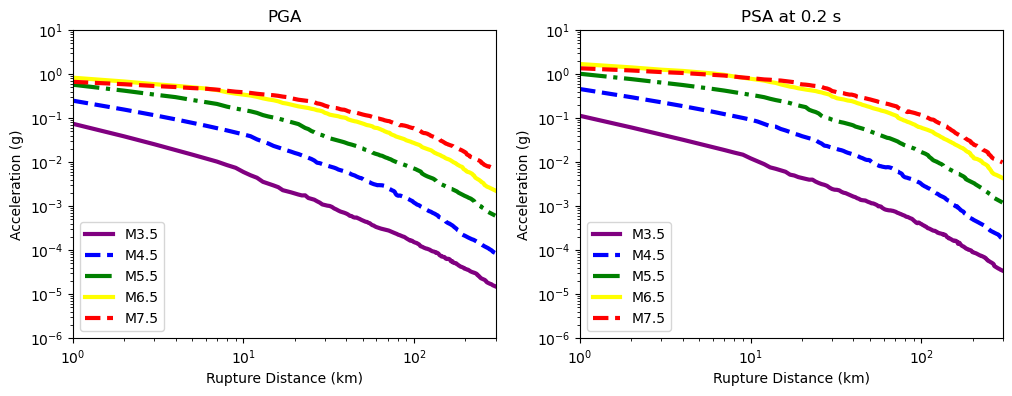

In [9]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA')
plt.subplot(1,2,2)
# PSA0.2 is column 8
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,8])
plt.title('PSA at 0.2 s')

# Prediction with VS30 = 760 m/s and Ztor = 0 km for PGA and PSA at 1.0 s

In [10]:
t0 = time.time()
df_plot = data_for_plot(Vs=[760], Ztor=[0])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
print("Running time: %.2f s" % (time.time()-t0))
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

Running time: 61.84 s


Text(0.5, 1.0, 'PSA at 1.0 s')

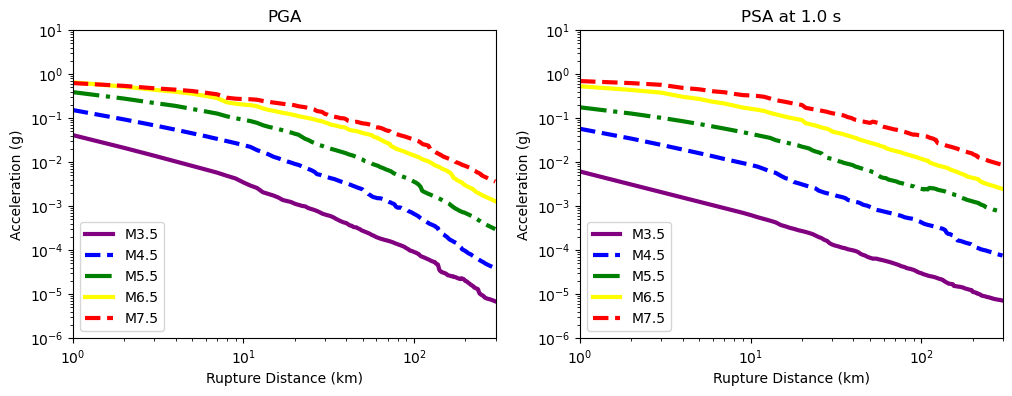

In [11]:
plt.figure(figsize = (12, 4))
plt.subplot(1,2,1)
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,0])
plt.title('PGA')
plt.subplot(1,2,2)
# PSA1 is column 14
plot_dist_scaling(df_plot, df_plot_predict_ensemble.iloc[:,14])
plt.title('PSA at 1.0 s')

### To see the predicted data in ln format

In [12]:
df_plot_predict_ensemble.head()

,PGA_g,T0pt010S,T0pt020S,T0pt030S,T0pt050S,T0pt075S,T0pt100S,T0pt150S,T0pt200S,T0pt250S,...,T1pt000S,T1pt500S,T2pt000S,T3pt000S,T4pt000S,T5pt000S,T7pt500S,T10pt000S,PGV_cm_sec,PGD_cm
0,-3.191218,-3.166408,-3.143788,-3.001544,-2.729082,-2.568780,-2.588422,-2.667933,-2.785385,-2.943807,...,-5.097828,-6.016976,-6.613695,-7.486581,-8.167760,-8.642558,-9.430188,-9.971520,-0.006101,-2.598459
1,-3.859999,-3.833901,-3.816936,-3.681604,-3.414822,-3.235486,-3.235535,-3.274091,-3.395525,-3.581191,...,-5.778088,-6.684872,-7.259366,-8.122523,-8.798307,-9.275672,-10.112436,-10.691041,-0.564609,-3.138824
2,-4.269874,-4.242804,-4.229984,-4.100108,-3.836815,-3.645691,-3.631746,-3.639527,-3.762457,-3.966888,...,-6.178799,-7.081308,-7.648004,-8.504462,-9.178057,-9.658337,-10.518740,-11.114496,-0.915826,-3.479936
3,-4.566942,-4.539159,-4.529581,-4.404203,-4.143419,-3.942813,-3.917588,-3.901927,-4.026042,-4.243787,...,-6.461855,-7.363088,-7.927125,-8.779234,-9.451403,-9.934224,-10.809294,-11.415095,-1.174807,-3.731918
4,-4.799994,-4.771688,-4.764712,-4.643157,-4.384391,-4.175479,-4.140760,-4.106883,-4.232071,-4.459554,...,-6.680614,-7.581738,-8.145338,-8.994558,-9.665566,-10.150499,-11.035841,-11.648279,-1.381033,-3.932558


### To see the predicted data in g or cm/s

In [13]:
np.exp(df_plot_predict_ensemble.tail())

,PGA_g,T0pt010S,T0pt020S,T0pt030S,T0pt050S,T0pt075S,T0pt100S,T0pt150S,T0pt200S,T0pt250S,...,T1pt000S,T1pt500S,T2pt000S,T3pt000S,T4pt000S,T5pt000S,T7pt500S,T10pt000S,PGV_cm_sec,PGD_cm
1490,0.003701,0.003678,0.003677,0.003722,0.003926,0.004415,0.005013,0.005772,0.006422,0.006818,...,0.008750,0.007983,0.006877,0.005054,0.004259,0.004400,0.005296,0.004513,1.701138,3.351666
1491,0.003680,0.003657,0.003656,0.003701,0.003902,0.004387,0.004982,0.005736,0.006385,0.006778,...,0.008716,0.007959,0.006859,0.005042,0.004249,0.004392,0.005293,0.004512,1.695950,3.347385
1492,0.003659,0.003637,0.003635,0.003680,0.003879,0.004360,0.004952,0.005701,0.006348,0.006739,...,0.008683,0.007934,0.006840,0.005030,0.004240,0.004384,0.005290,0.004511,1.690793,3.343125
1493,0.003639,0.003616,0.003614,0.003659,0.003856,0.004333,0.004921,0.005667,0.006312,0.006701,...,0.008650,0.007910,0.006822,0.005018,0.004231,0.004376,0.005286,0.004511,1.685667,3.338885
1494,0.003618,0.003596,0.003594,0.003638,0.003833,0.004306,0.004891,0.005633,0.006276,0.006662,...,0.008617,0.007886,0.006804,0.005006,0.004222,0.004368,0.005283,0.004510,1.680572,3.334666


### Plotting each inividual ML models abd the ensemble

In [14]:
# if you want to see for different Vs30 and Ztor you should run below otherwise skip it
df_plot = data_for_plot(Vs=[400], Ztor=[5])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

(1, 300)

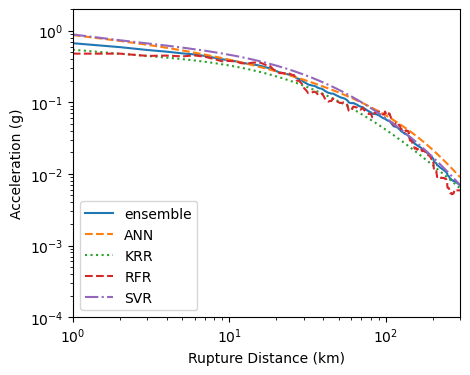

In [15]:
# define the magnitude and period that you are interested in
mag = 7.5
T_period = 0

ML = plt.figure(figsize = (5,4))
d = list(set(df_plot['ClstD_km'].tolist()))
d.sort()
idx = df_plot[df_plot.Earthquake_Magnitude == mag].index.to_list()
plt.loglog(d, np.exp(df_plot_predict_ensemble.iloc[idx,T_period]),label = 'ensemble')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_ANN).iloc[idx,T_period]),'--',label = 'ANN')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_KRR).iloc[idx,T_period]),':',label = 'KRR')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_RFR).iloc[idx,T_period]),'--',label = 'RFR')
plt.loglog(d, np.exp(pd.DataFrame(df_plot_predict_SVR).iloc[idx,T_period]),'-.',label = 'SVR')

plt.legend()
plt.xlabel('Rupture Distance (km)')
plt.ylabel('Acceleration (g)')
plt.ylim([0.0001, 2])
plt.xlim([1, 300])

### Plot response spectra

In [16]:
# if you want to see for different Vs30 and Ztor you should run below otherwise skip it
df_plot = data_for_plot(Vs=[400], Ztor=[10])
df_plot_predict_ANN =  ANN.predict(df_plot)
df_plot_predict_KRR =  KRR.predict(df_plot)
df_plot_predict_RFR =  RFR.predict(df_plot)
df_plot_predict_SVR =  SVR.predict(df_plot)
df_plot_predict_ensemble =df_plot_predict_RFR*w[0] + df_plot_predict_ANN*w[1] + df_plot_predict_KRR*w[2] + df_plot_predict_SVR*w[3]
df_plot_predict_ensemble = pd.DataFrame(df_plot_predict_ensemble, columns = periods)

(0.01, 10)

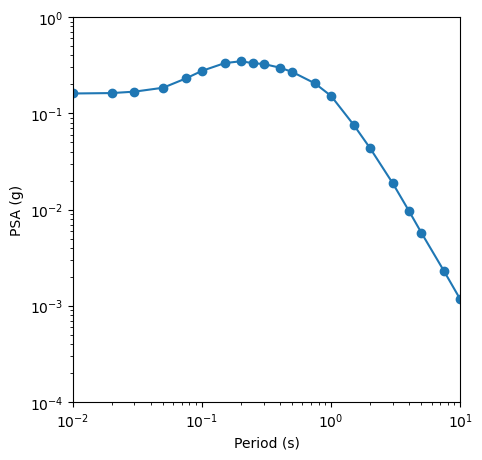

In [17]:
r = 35
mag = 6.5
response=plt.figure(figsize = (5,5))
plt.loglog(T,np.exp(df_plot_predict_ensemble.iloc[df_plot[(df_plot.Earthquake_Magnitude == mag) & (df_plot.ClstD_km == r)].index[0],1:22]),'o-')

plt.xlabel('Period (s)')
plt.ylabel('PSA (g)')
plt.ylim([0.0001, 1])
plt.xlim([0.01, 10])